# 使用 NumPy 完成卷积神经网络 CNN 的搭建

整个网络创建三个层模块

    卷积层（Conv）
    ReLu 激活函数
    最大池化（max pooling）

## 一、读取输入图像

In [1]:
import skimage.data
import matplotlib.pyplot as plt
import numpy
import sys

# 从 skimage Python 库中读取已经存在的图像，并将其转换为灰度图

# Reading the image
img_ori = skimage.data.chelsea()

# Converting the image into gray.
img = skimage.color.rgb2gray(img_ori)

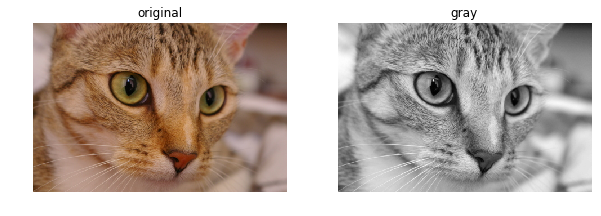

In [2]:
# 显示原始图和灰度图
fig0 = plt.figure(figsize=(10,10))
ax0_1 = fig0.add_subplot(1, 2, 1)
ax0_1 = plt.imshow(img_ori)
plt.title('original')
plt.axis('off')
ax0_2 = fig0.add_subplot(1, 2, 2)
ax0_2 = plt.imshow(img).set_cmap("gray")
plt.title('gray')
plt.axis('off')
plt.show()

##  二、准备滤波器

In [3]:
# First conv layer
# Preparing the filters randomly
l1_filter = numpy.zeros((2,3,3))

上述代码创建了 2 个 3x3 大小的滤波器

    2：滤波器的数目（num_filters）
    3：表示滤波器的列数
    3：表示滤波器的行数
    
由于输入图像是灰度图，读取后变成 2 维图像矩阵，因此滤波器的尺寸选择为 2 维阵列，舍去了深度.

滤波器组的大小由自己指定，但没有给定滤波器中具体的数值，一般采用随机初始化。下列一组值可以用来检查垂直和水平边缘.

In [4]:
# 检查垂直和水平边缘
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
l1_filter[1, :, :] = numpy.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])

## 三、卷积层（Conv Layer）

构建好滤波器后，接下来就是与输入图像进行卷积操作。

In [5]:
# 使用 conv 函数将输入图像与滤波器组进行卷积
# conv 函数只接受两个参数，分别为输入图像、滤波器组
def conv(img, conv_filter):
    
    # 首先确保每个滤波器的深度等于图像通道的数目
    # if 语句首先检查图像与滤波器是否有一个深度通道，若存在，则检查其通道数是否相等，如果匹配不成功，则报错
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
            
    # 此外，滤波器的大小应该是奇数，且每个滤波器的大小是相等的
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    # 即, 初始化一个数组来作为滤波器的值
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # 由于没有设置步幅（stride）或填充（padding），默认为步幅设置为 1，无填充
    # 卷积操作后得到的特征图大小为（img_rows-filter_rows+1, image_columns-filter_columns+1, num_filters）
    # 即输入图像的尺寸减去滤波器的尺寸后再加 1
    # 每个滤波器都会输出一个特征图
    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        
        # 循环遍历滤波器组中的每个滤波器后，通过下面代码更新滤波器的状态
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        
        
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        下面的代码检测输入图像的通道数,
        如果图像只有一个通道，那么一次卷积即可完成整个过程,
        最后将每个滤波器的输出求和作为输出特征图.
        如果输入图像不止一个通道，则滤波器必须具有同样的通道数目.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
            
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

In [6]:
# 函数 conv 只接受输入图像和滤波器组这两个参数，本身并不进行卷积操作，它只是设置用于 conv_ 函数执行卷积操作的每一组输入滤波器
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[0]
    result = numpy.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in numpy.uint16(numpy.arange(filter_size/2, 
                          img.shape[0]-filter_size/2-2)):
        for c in numpy.uint16(numpy.arange(filter_size/2, img.shape[1]-filter_size/2-2)):
            # Getting the current region to get multiplied with the filter.
            
            # 实现每个滤波器在图像上迭代卷积的尺寸相同
            curr_region = img[r:r+filter_size, c:c+filter_size]
            
            # Element-wise multipliplication between the current region and the filter.
            # 在图像区域矩阵和滤波器之间对位相乘，并将结果求和以得到单值输出
            curr_result = curr_region * conv_filter
            conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    # Clipping the outliers of the result matrix.
    final_result = result[numpy.uint16(filter_size/2):result.shape[0]-numpy.uint16(filter_size/2), 
                          numpy.uint16(filter_size/2):result.shape[1]-numpy.uint16(filter_size/2)]
    return final_result

Filter  1
Filter  2


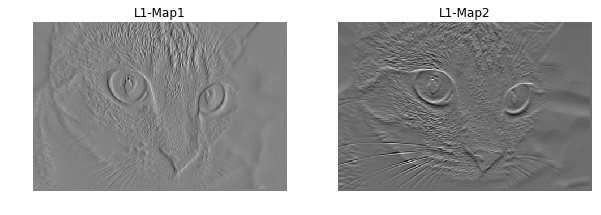

In [7]:
# 输入图像与每个滤波器卷积后，通过 conv 函数返回特征图
# 由于 l1 卷积层的滤波器参数为（2,3,3），即 2 个 3x3 大小的卷积核，最终输出 2 个特征图
l1_feature_map = conv(img, l1_filter)

fig1 = plt.figure(figsize=(10,10))
ax1_1 = fig1.add_subplot(1, 2, 1)
ax1_1 = plt.imshow(l1_feature_map[:, :, 0]).set_cmap("gray")
plt.title('L1-Map1')
plt.axis('off')
ax1_2 = fig1.add_subplot(1, 2, 2)
ax1_2 = plt.imshow(l1_feature_map[:, :, 1]).set_cmap("gray")
plt.title('L1-Map2')
plt.axis('off')
plt.show()

## 四、ReLU 激活函数层

卷积层的后面一般跟着激活函数层，这里采用 ReLU 激活函数.

ReLU 层将 ReLU 激活函数应用于 conv 层输出的每个特征图上.

In [8]:
# ReLU 思想很简单，只是将特征图中的每个元素与 0 进行比较，若大于 0，则保留原始值。否则将其设置为 0
def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = numpy.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in numpy.arange(0,feature_map.shape[0]):
            for c in numpy.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = numpy.max(feature_map[r, c, map_num], 0)
    return relu_out

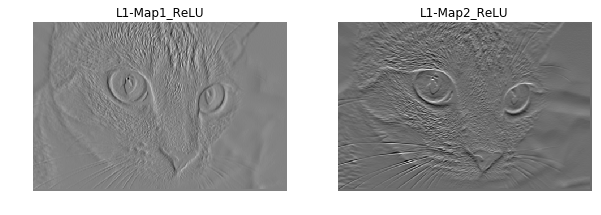

In [9]:
# 调用 ReLU 激活函数
l1_feature_map_relu = relu(l1_feature_map)

# ReLU 层的输出
fig2 = plt.figure(figsize=(10,10))
ax2_1 = fig2.add_subplot(1, 2, 1)
ax2_1 = plt.imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")
plt.title('L1-Map1_ReLU')
plt.axis('off')
ax2_2 = fig2.add_subplot(1, 2, 2)
ax2_2 = plt.imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")
plt.title('L1-Map2_ReLU')
plt.axis('off')
plt.show()

## 五 、最大池化层

激活函数层后面一般紧跟池化层，本文采用最大池化（max pooling）.

In [10]:
# 最大池化函数（max pooling）的具体实现代码
# 该函数接受 3 个参数，分别为 ReLU 层的输出，池化掩膜的大小和步幅
def pooling(feature_map, size=2, stride=2):
    
    #Preparing the output of the pooling operation.
    # 首先创建一个空数组，用来保存该函数的输出
    # 数组大小根据输入特征图的尺寸、掩膜大小以及步幅来确定
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride),
                            numpy.uint16((feature_map.shape[1]-size+1)/stride),
                            feature_map.shape[-1]))
    
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in numpy.arange(0,feature_map.shape[0]-size-1, stride):
            c2 = 0
            for c in numpy.arange(0, feature_map.shape[1]-size-1, stride):
                
                # 对每个输入特征图通道都进行最大池化操作，返回该区域中最大的值
                pool_out[r2, c2, map_num] = numpy.max(feature_map[r:r+size,  c:c+size])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

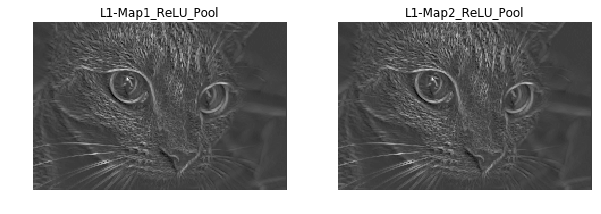

In [11]:
# ReLU 层的输出作为最大池化层的输入，根据下面的代码行调用最大池化操作
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

# 池化层输出图像
fig3 = plt.figure(figsize=(10,10))
ax3_1 = fig3.add_subplot(1, 2, 1)
ax3_1 = plt.imshow(l1_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
plt.title('L1-Map1_ReLU_Pool')
plt.axis('off')
ax3_2 = fig3.add_subplot(1, 2, 2)
ax3_2 = plt.imshow(l1_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
plt.title('L1-Map2_ReLU_Pool')
plt.axis('off')
plt.show()

## 六、层堆叠

以上内容已经实现 CNN 结构的基本层——conv、ReLU 以及 max pooling，现在将其进行堆叠使用.

In [12]:
# Second conv layer
'''
l2 表示第二个卷积层，该卷积层使用的卷积核为（3,5,5）
即 3 个 5x5 大小的卷积核（滤波器）与第一层的输出进行卷积操作，得到 3 个特征图
后续接着进行 ReLU 激活函数以及最大池化操作
'''
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
l2_feature_map_relu = relu(l2_feature_map)
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)

Filter  1
Filter  2
Filter  3


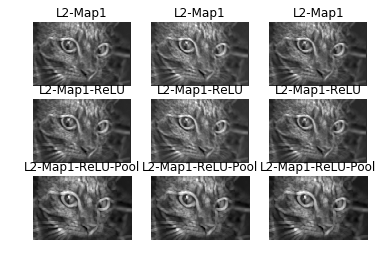

In [13]:
# 将每个操作的结果可视化，如下图所示
fig4 = plt.figure()
ax4_1_1 = fig4.add_subplot(3, 3, 1)
ax4_1_1 = plt.imshow(l2_feature_map[:, :, 0]).set_cmap("gray")
plt.title('L2-Map1')
plt.axis('off')
ax4_1_2 = fig4.add_subplot(3, 3, 2)
ax4_1_2 = plt.imshow(l2_feature_map[:, :, 1]).set_cmap("gray")
plt.title('L2-Map1')
plt.axis('off')
ax4_1_3 = fig4.add_subplot(3, 3, 3)
ax4_1_3 = plt.imshow(l2_feature_map[:, :, 2]).set_cmap("gray")
plt.title('L2-Map1')
plt.axis('off')
ax4_2_1 = fig4.add_subplot(3, 3, 4)
ax4_2_1 = plt.imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")
plt.title('L2-Map1-ReLU')
plt.axis('off')
ax4_2_2 = fig4.add_subplot(3, 3, 5)
ax4_2_2 = plt.imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")
plt.title('L2-Map1-ReLU')
plt.axis('off')
ax4_2_3 = fig4.add_subplot(3, 3, 6)
ax4_2_3 = plt.imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")
plt.title('L2-Map1-ReLU')
plt.axis('off')
ax4_3_1 = fig4.add_subplot(3, 3, 7)
ax4_3_1 = plt.imshow(l2_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
plt.title('L2-Map1-ReLU-Pool')
plt.axis('off')
ax4_3_2 = fig4.add_subplot(3, 3, 8)
ax4_3_2 = plt.imshow(l2_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
plt.title('L2-Map1-ReLU-Pool')
plt.axis('off')
ax4_3_3 = fig4.add_subplot(3, 3, 9)
ax4_3_3 = plt.imshow(l2_feature_map_relu_pool[:, :, 2]).set_cmap("gray")
plt.title('L2-Map1-ReLU-Pool')
plt.axis('off')
plt.show()

In [14]:
'''
l3 表示第三个卷积层，该卷积层使用的卷积核为（1,7,7）
即 1 个 7x7 大小的卷积核（滤波器）与第二层的输出进行卷积操作，得到 1 个特征图
后续接着进行 ReLU 激活函数以及最大池化操作
'''
# Third conv layer
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
l3_feature_map_relu = relu(l3_feature_map)
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)

Filter  1


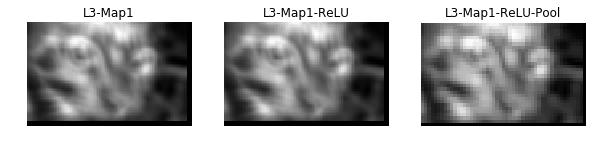

In [15]:
# 将每个操作的结果可视化
fig5 = plt.figure(figsize=(10,10))
ax5_1 = fig5.add_subplot(1, 3, 1)
ax5_1 = plt.imshow(l3_feature_map[:, :, 0]).set_cmap("gray")
plt.title('L3-Map1')
plt.axis('off')
ax5_2 = fig5.add_subplot(1, 3, 2)
ax5_2 = plt.imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")
plt.title('L3-Map1-ReLU')
plt.axis('off')
ax5_3 = fig5.add_subplot(1, 3, 3)
ax5_3 = plt.imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
plt.title('L3-Map1-ReLU-Pool')
plt.axis('off')
plt.show()

[reference](https://github.com/ahmedfgad/NumPyCNN/blob/master/README.md)